\documentclass[english,article,a4paper]{memoir}

% input the common preamble content (required by the ipnb2latex converter)
\input{header.tex}
\counterwithout{section}{chapter}
\setsecnumformat{}


%and finally the document begin.
\begin{document}


## Create simple topograpy maps for LandLab

This notebook provides a tool to create three types of terrain topography files for experimentation in LandLab. 


The functions included here allows the user to calculate different terrains, based on the different input parameters to the generating functions.  The different types are:

1. A tilted plane. The plane can be tilted in any direction by any magnitude.
2. A valley defined by two tilted planes
3. A simple fractal terrain.

In [1]:
import numpy as np
import random as rnd
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.ndimage.filters

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

%matplotlib inline

## Landlab documentation

1. https://github.com/landlab/landlab/wiki
1. https://github.com/landlab/landlab/wiki/Grid  
1. https://github.com/landlab/landlab/wiki/User-Guide
1. https://media.readthedocs.org/pdf/landlab/latest/landlab.pdf


## ASC file format

The Esri ASCII raster format can be used to transfer information to or from other cell-based or raster systems. When an existing raster is output to an Esri ASCII-format raster, the file will begin with header information that defines the properties of the raster such as the cell size, the number of rows and columns, and the coordinates of the origin of the raster. The header information is followed by cell value information specified in space-delimited row-major order, with each row separated by a carriage return.


To convert an ASCII file to a raster, the data must be in this same format. The parameters in the header part of the file must match correctly with the structure of the data values.


The basic structure of the Esri ASCII raster has the header information at the beginning of the file followed by the cell value data. The spatial location of the raster is specified by the location of the lower left cell, and either by:


The center of the lower left cell  

    NCOLS xxx
    NROWS xxx
    XLLCENTER xxx
    YLLCENTER xxx
    CELLSIZE xxx
    NODATA_VALUE xxx
    row 1
    row 2
    ...
    row n


The lower left corner of the lower left cell  

    NCOLS xxx
    NROWS xxx
    XLLCORNER xxx
    YLLCORNER xxx
    CELLSIZE xxx
    NODATA_VALUE xxx
    row 1
    row 2
    ...
    row n


Row 1 of the data is at the top of the raster, row 2 is just under row 1, and so on.

### Header format

The syntax of the header information is a keyword paired with the value of that keyword. These are the definitions of the keywords:

| Parameter | Description | Requirements |
|:--- |:--- |:--- |
| NCOLS | Number of cell columns | Integer greater than 0.|
| NROWS | Number of cell rows| Integer greater than 0.|
| XLLCENTER or XLLCORNER | X-coordinate of the origin | Match with y-coordinate  type.|
|   | (by center or lower left corner of the cell) |  |
| YLLCENTER or YLLCORNER | Y-coordinate of the origin  | Match with x-coordinate type.|
|   |  (by center or lower left corner of the cell) | |
|CELLSIZE | Cell size  | Greater than 0.|
| NODATA_VALUE |The input values to be NoData in the output raster| Optional. Default is -9999.|


#### Data format
The data component of the Esri ASCII raster follows the header information.

1. Cell values should be delimited by spaces.
1. No carriage returns are necessary at the end of each row in the raster. The number of columns in the header determines when a new row begins.
1. Row 1 of the data is at the top of the raster, row 2 is just under row 1, and so on.

### Example ASCII raster

    ncols 480
    nrows 450
    xllcorner 378923
    yllcorner 4072345
    cellsize 30
    nodata_value -32768
    43 2 45 7 3 56 2 5 23 65 34 6 32 54 57 34 2 2 54 6 
    35 45 65 34 2 6 78 4 2 6 89 3 2 7 45 23 5 8 4 1 62 ...

### References

1. http://resources.esri.com/help/9.3/arcgisdesktop/com/gp_toolref/spatial_analyst_tools/esri_ascii_raster_format.htm  
1. https://resources.arcgis.com/en/help/main/10.1/index.html
1. https://gis.stackexchange.com/questions/71867/understanding-esris-asc-file  
    

The ASC file is an ASCII file for raster GIS data. It is not necessarily only for DEM data, presumably any raster data can be stored in this format?


## LandLab ASC functions

https://landlab.readthedocs.io/en/release/landlab.io.esri_ascii.html
    

ESRI ASCII functions  (link above has example python code).

1. read_asc_header(asc_file)	Read header information from an ESRI ASCII raster file.
1. read_esri_ascii(asc_file[, grid, reshape, ...])	Read RasterModelGrid from an ESRI ASCII file.
1. write_esri_ascii(path, fields[, names, clobber])	Write landlab fields to ESRI ASCII.    


## Writing ASC DEM files



`writeASCDEM` takes a two-dimensional grid (numpy array) and the required parameters to write the grid information to an ASC file.  The function parameters are explained in the file docstring.

In [2]:
def writeASCDEM(filename, grid, cellsize, xllcorner=0., yllcorner=0., nodata_value=0):
    """ Writes a pre-calculated grid to an ESRI ASC format
 
    Args:
        | fileName (string): output file name with full path
        | grid (np.array): two-dimensional numpy array with grid values
        | cellsize (int or float): size of one cell in the grid (assumed isotropic)
        | xllcorner (int or float): x coordinate of the lower left corner
        | yllcorner (int or float): y coordinate of the lower left corner
        | nodata_value (int or float): data to be used if none is present in ASC file

    Returns:
        | Nothing, as side effect the file is written to disk

    Raises:
        | No exception is raised.
    """    
    
    # get number of rows and cols from the grid itself
    ncols = grid.shape[1]
    nrows = grid.shape[0]
    
    with open(filename,'wb') as fout:
        fout.write('ncols {}\n'.format(ncols).encode()) # to give byte string
        fout.write('nrows {}\n'.format(nrows).encode())
        fout.write('xllcorner {}\n'.format(xllcorner).encode())
        fout.write('yllcorner {}\n'.format(yllcorner).encode())
        fout.write('cellsize {}\n'.format(cellsize).encode())
        fout.write('nodata_value {}\n'.format(nodata_value).encode())
        np.savetxt(fout, grid.astype(float), fmt='%.6e', delimiter=' ', newline='\n')
        

The following example writes a random field out as an ASC file. This is not a valid topography, it only serves to demonstrate writing the file.

In [3]:
grid = np.random.rand(4,6)
writeASCDEM('random.asc', grid, cellsize=30)

## Flat, tilted plane

The topography is modelled by a plane defined by the normal vector to the plane and the altitude of the lower left corner.

The general equation for a plane is given by $Ax+By+Cz+D=0$ where $A$, $B$,and $C$ are the $x,y,z$ components of a vector normal to the plane. It normal vector need not be normalised to unity value. If the plane passes through the origin, $D=0$, then $z = (Ax+By)/C$. If the plane is perfectly level $(A,B,C)=(0,0,1)$.



In [4]:
def createPlane(ncols,nrows,tilt=10.,azim=0.,cellsize=1):
    """ Creates a flat plane in prescribed tilt and azimuth angles
    
    The plane is described by the direction of its normal vector.
    The normal vector tilts from the vertical, pointing along the azimuth direction.
    Azimuth of zero or 360 deg points towards +x or the East.
    Tilt of zero points vertically up, plan is horisontal.    
    
    The number of rows/cols and cell size are used to calculate x/y coordinates.
    
    The plane passes through the origin (0,0,0), the user must lift or lower as necessary.
 
    Args:
        | ncols (int): number of grid columns (along x) 
        | nrows (int): number of grid rows (along y) 
        | tilt (float): tilt angle [degrees] of the plane normal vector
        | azim (float): azimuth angle [degrees] of the plane normal vector
        | cellsize (int or float):  size of one cell in the grid (assumed isotropic)

    Returns:
        | x (np.array): two-dimensional array, values varying in x direction
        | y (np.array): two-dimensional array, values varying in y direction
        | grid (np.array): two-dimensional array, plane values

    Raises:
        | No exception is raised.
    """    
    
    C = np.cos(tilt*np.pi/180.)
    zd =  - np.abs(np.sin(tilt*np.pi/180.))
    A = zd * np.cos(azim*np.pi/180.)
    B = zd * np.sin(azim*np.pi/180.)
    
    varx = np.linspace(-cellsize * ncols/2., cellsize * ncols/2., ncols)
    vary = np.linspace(-cellsize * nrows/2., cellsize * nrows/2., nrows)
    x, y = np.meshgrid(varx, vary)

    grid = (A * x + B * y  ) / C
    
    return x,y,grid

In [5]:

def plotTopo(x,y,grid,filename,pngFile='none'):
    """ Plot the topography, given x,y, and grid values.

    An image graph and contour plot are created. 
    If the topography is horisontal, the contour plot is not drawn.
 
    Args:
        | x (np.array): two-dimensional array, values varying in x direction
        | y (np.array): two-dimensional array, values varying in y direction
        | grid (np.array): two-dimensional array, plane values
        | filename (string): filename used in the plot header
        | pngFile (string): output png file name (written if not none)

    Returns:
        | Nothing

    Raises:
        | No exception is raised.
    """    
    plt.figure(num=None, figsize=(12,5),dpi=150)
    plt.subplot(1,2,1)
    im = plt.imshow(grid, interpolation='bilinear', origin='lower',cmap=cm.gray)
    CBI = plt.colorbar(im,  shrink=0.8)
    plt.title('Cell image: {}'.format(filename))
    
    if np.unique(grid).shape[0] > 1:
        plt.subplot(1,2,2)
        levels = np.linspace(np.min(grid),np.max(grid),10)
        CS = plt.contour(x,y,grid, levels, origin='lower', linewidths=2,colors='k')#,extent=(-3, 3, -2, 2))
#         plt.clabel(CS, levels,inline=1,fmt='%1.1f',fontsize=14)
        plt.axis('equal')
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.title('Altitude: {}'.format(filename))
        plt.grid(True)
        if 'none' not in pngFile:
            plt.savefig(pngFile,dpi=300)
    else:
        print('Topography is horizontal with altitude {} m'.format(np.unique(grid)[0]))

    

## Flat tilted topography

The topography created by this function is a perfectly flat tilted surface. It is therefore the most simple watershed possible, with a guaranteed exit (all water will leave the terrain).

In [6]:
def createFlatTopo(filecore,ncols,nrows,tilt=10.,azim=0.,cellsize=1,llcorner=[0.,0.,0.]):
    """ Creates a plane or flat topography, tilted along azimuth angle
    
    The topography is described by the direction of its normal vector.
    The normal vector tilts from the vertical, pointing along the azimuth direction.
    Azimuth of zero or 360 deg points towards +x or the East.
    Tilt of zero points vertically up, plan is horisontal.    
    
    The number of rows/cols and cell size are used to calculate x/y coordinates.
    
    The plane lower left corner is set to the values in llcorner.
    
 
    Args:
        | filecore (string): first part of the filename 
        | ncols (int): number of grid columns (along x) 
        | nrows (int): number of grid rows (along y) 
        | tilt (float): tilt angle [degrees] of the plane normal vector
        | azim (float): azimuth angle [degrees] of the plane normal vector
        | cellsize (int or float):  size of one cell in the grid (assumed isotropic)
        | llcorner ([int or float]): [x,y,z] coordinates of the lower left corner

    Returns:
        | x (np.array): two-dimensional array, values varying in x direction
        | y (np.array): two-dimensional array, values varying in y direction
        | grid (np.array): two-dimensional array, plane values
        | filename (string): filename used in the plot header
        | as a side effect, the file is also written to disk

    Raises:
        | No exception is raised.
    """    

    x,y,grid = createPlane(ncols,nrows,tilt,azim,cellsize)
    gridll = grid[0,0]
    grid = grid - gridll + llcorner[2]
    
    filename = '{}_[{},{},{}][{},{}].asc'.format(filecore,ncols,nrows,cellsize,tilt,azim)
    print('Writing file {}'.format(filename))
    writeASCDEM(filename,grid,cellsize,xllcorner=llcorner[0], yllcorner=llcorner[1])

    return x,y,grid,filename


Writing file slope_[30,30,20][10.0,0.0].asc


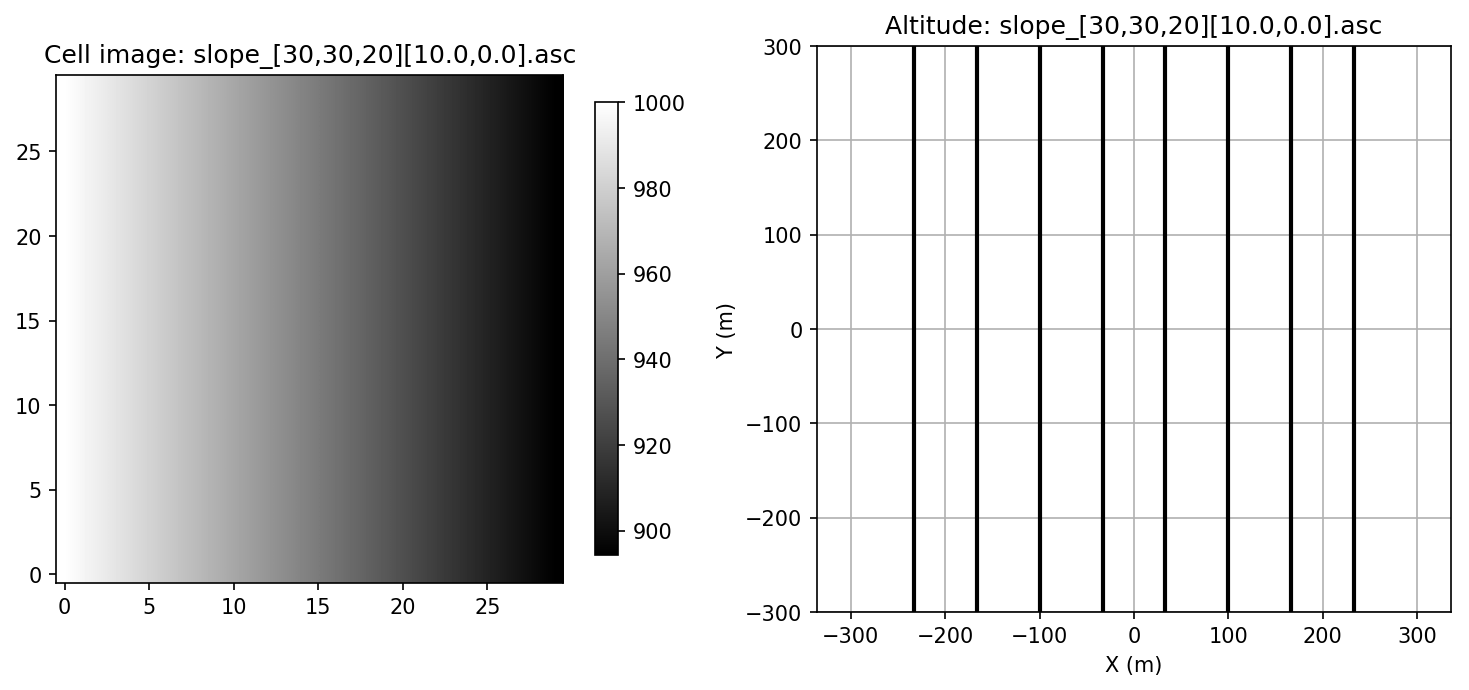

In [7]:
x,y,grid,filename = createFlatTopo('slope',ncols=30,nrows=30,tilt=10.,
                                   azim=0.0,cellsize=20,llcorner=[0.,0.,1000.])
plotTopo(x,y,grid,filename,'slope_[30,30,20][10.0,0.0].png')

## Flat valley topography

The topography created by this function is a valley formed by two perfectly flat tilted surfaces. There is one watershed, the valley with a guaranteed exit (all water will leave the terrain).

In [8]:
def createValleyTopo(filecore,ncols,nrows,tilt1=0.,azim1=0.,tilt2=0.,azim2=0.,cellsize=1,llcorner=[0.,0.,0.]):
    """ Creates a valley topography defined by two tilted planes
    
    The topography is described by the directions of its two normal vectors.
    The normal vector tilts from the vertical, pointing along the azimuth direction.
    Azimuth of zero or 360 deg points towards +x or the East.
    Tilt of zero points vertically up, plan is horisontal.  
    
    The topography is taken to be the highest of the two planes
    
    The number of rows/cols and cell size are used to calculate x/y coordinates.
    
    The plane lower left corner is set to the values in llcorner.
    
 
    Args:
        | filecore (string): first part of the filename 
        | ncols (int): number of grid columns (along x) 
        | nrows (int): number of grid rows (along y) 
        | tilt1 (float): tilt angle [degrees] of the first plane normal vector
        | azim1 (float): azimuth angle [degrees] of the first plane normal vector
        | tilt2 (float): tilt angle [degrees] of the second plane normal vector
        | azim2 (float): azimuth angle [degrees] of the second plane normal vector
        | cellsize (int or float):  size of one cell in the grid (assumed isotropic)
        | llcorner ([int or float]): [x,y,z] coordinates of the lower left corner

    Returns:
        | x (np.array): two-dimensional array, values varying in x direction
        | y (np.array): two-dimensional array, values varying in y direction
        | grid (np.array): two-dimensional array, plane values
        | filename (string): filename used in the plot header
        | as a side effect, the file is also written to disk

    Raises:
        | No exception is raised.
    """    
    x1,y1,grid1 = createPlane(ncols,nrows,tilt1,azim1,cellsize)
    x2,y2,grid2 = createPlane(ncols,nrows,tilt2,azim2,cellsize)
    grid = np.maximum(grid1,grid2)
    
    gridll = grid[0,0]
    grid = grid - gridll + llcorner[2]
    
    row2 = int(nrows/2.)
    col2 = int(ncols/2.)
    
    r = np.sqrt((cellsize*row2)*(cellsize*row2) + (cellsize*col2)*(cellsize*col2))
    flatslope = np.arctan((grid[0,0]-grid[row2-1,col2-1])/(r))*180/np.pi
    valleyslope = np.arctan((grid[nrows-1,0]-grid[row2-1,col2-1])/(r))*180/np.pi

    print('flatslope={:.3f} deg'.format(flatslope))
    print('valleyslope={:.3f} deg'.format(valleyslope))

    
    filename = '{}{:.2f}_[{},{},{}][{:.2f},{:.2f},{:.2f},{:.2f}].asc'.format(filecore,flatslope,ncols,nrows,cellsize,tilt1,azim1,tilt2,azim2)
    print('Writing file {}'.format(filename))
    writeASCDEM(filename,grid,cellsize,xllcorner=llcorner[0], yllcorner=llcorner[1])

    return x1,y1,grid,filename


flatslope=20.639 deg
valleyslope=20.639 deg
Writing file valley20.64_[100,100,10][28.28,0.00,-28.28,270.00].asc


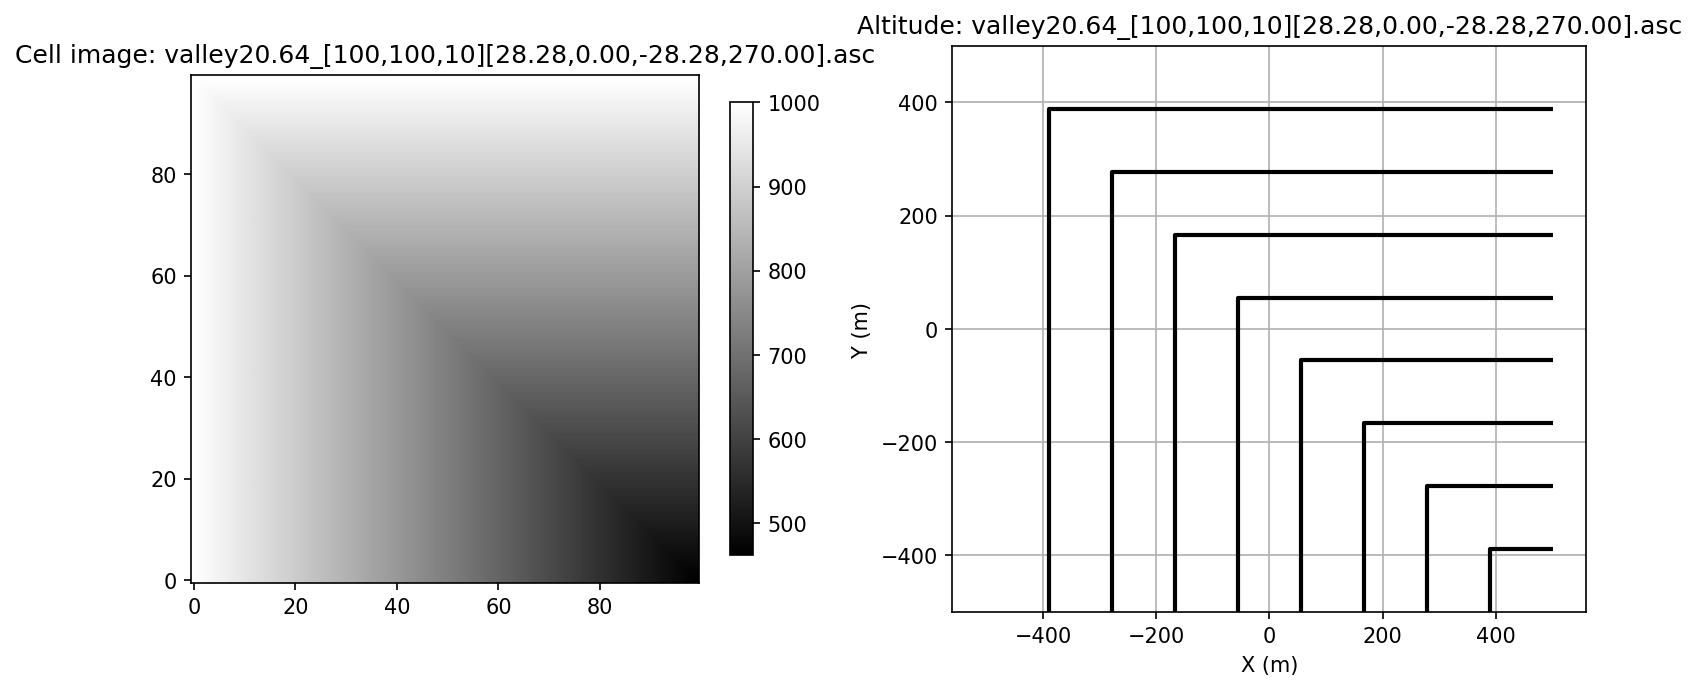

In [9]:
down = 20*np.sqrt(2) 
valg = 45  
x,y,grid,filename = createValleyTopo('valley',ncols=100,nrows=100,
                                     tilt1=down,azim1=45.-valg,tilt2=-down,azim2=180+45.+valg,
                                     cellsize=10,llcorner=[0.,0.,1000.])

plotTopo(x,y,grid,filename,'valley20.64_[100,100,10][28.28,0.00,-28.28,270.00].png')


## Fractal terrain topography

The fractal topography generator is taken from here:  
https://github.com/dafarry/python-fractal-landscape/blob/master/fractal-mountain.py  

There is an error in this code, because the terrains have some correlation between x and y, the terrains are not fully random.  It is however a short code and the results may be useful, even if all mathematical requirements are not met in the implementation.

The topography created by this function is a random fractal surface. It is a complex watershed model, without a guaranteed exit (not all water will leave the terrain, some water will be captured in local lakes).

In [10]:

def createFractalTopo(filecore,levels=5,seed=10,cellsize=1,llcorner=[0.,0.,0.]):
    """ Creates a fractal topography 
    
    https://github.com/dafarry/python-fractal-landscape/blob/master/fractal-mountain.py
    
    The terrain size is 2**(levels-1)

    Use different seed values to create different terrains.    
    
    The plane lower left corner is set to the values in llcorner.
    
 
    Args:
        | filecore (string): first part of the filename 
        | levels (int): recursion depth, determines the terrain size
        | seed (int): the number used to seed the random number generator
        | cellsize (int or float):  size of one cell in the grid (assumed isotropic)
        | llcorner ([int or float]): [x,y,z] coordinates of the lower left corner

    Returns:
        | x (np.array): two-dimensional array, values varying in x direction
        | y (np.array): two-dimensional array, values varying in y direction
        | grid (np.array): two-dimensional array, plane values
        | filename (string): filename used in the plot header
        | as a side effect, the file is also written to disk

    Raises:
        | No exception is raised.
    """    

    size = 2 ** (levels - 1)
    grid  = np.zeros((size + 1, size + 1))
    rnd.seed(seed)
    for lev in range(levels):
        step = size // 2 ** lev
        for y in range(0, size + 1, step):
            jumpover = 1 - (y // step) % 2 if lev > 0 else 0
            for x in range(step * jumpover, size + 1, step * (1 + jumpover)):
                pointer = 1 - (x // step) % 2 + 2 * jumpover if lev > 0 else 3
                yref, xref = step * (1 - pointer // 2), step * (1 - pointer % 2)
                corner1 = grid[y - yref, x - xref]
                corner2 = grid[y + yref, x + xref]
                average = (corner1 + corner2) / 2.0
                variation = step * (rnd.random() - 0.5)
                grid[y,x] = average + variation if lev > 0 else 0
                
    grid = grid - grid[0,0] + llcorner[2]
    
    varx = np.linspace(0, cellsize * grid.shape[1], grid.shape[1])
    vary = np.linspace(0, cellsize * grid.shape[0], grid.shape[0])
    xx, yy = np.meshgrid(varx, vary)

    ncols = grid.shape[1]
    nrows = grid.shape[0]                
    filename = '{}_[{},{}][{},{},{}].asc'.format(filecore,levels,seed,ncols,nrows,cellsize)
    print('Writing file {}'.format(filename))
    writeASCDEM(filename,grid,cellsize,xllcorner=llcorner[0], yllcorner=llcorner[1])

    return xx,yy,grid,filename

Writing file fractal_[7,189][65,65,10].asc


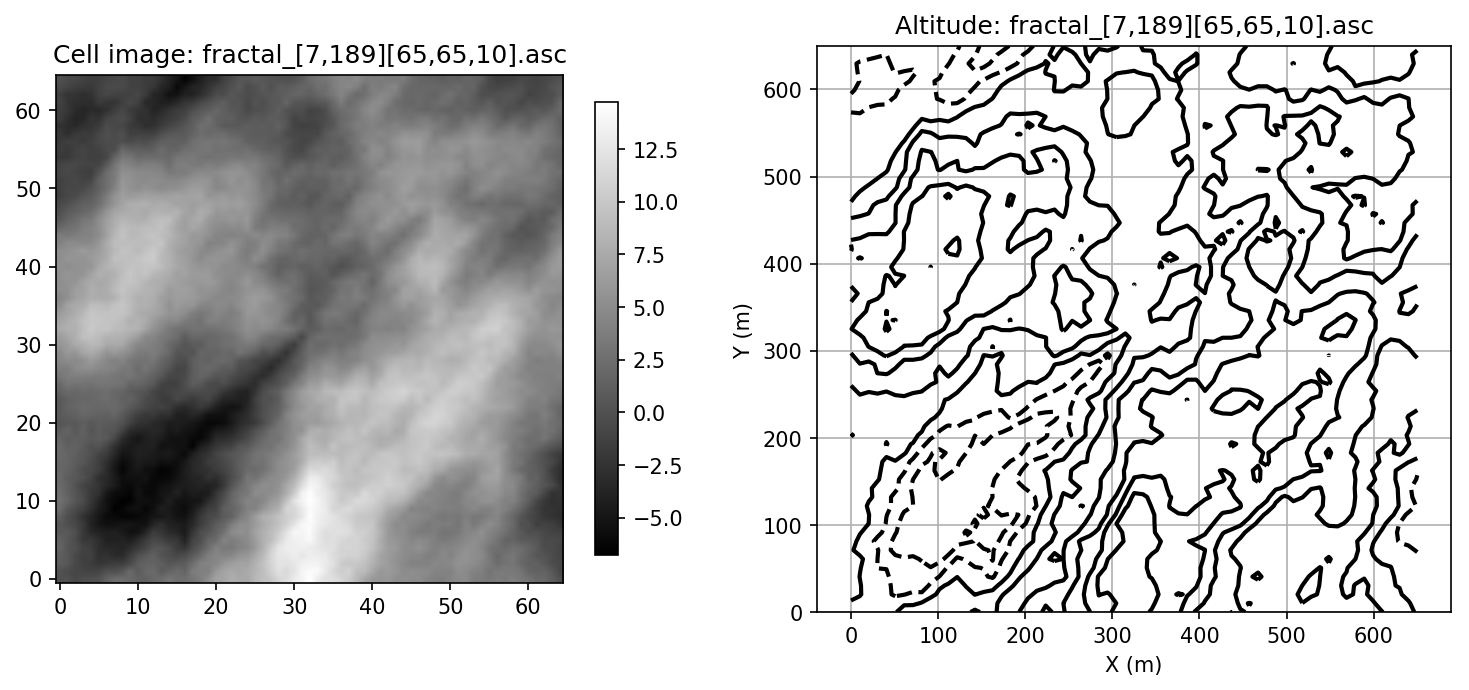

In [11]:
x,y,grid,filename = createFractalTopo('fractal',levels=7,seed=189,cellsize=10,llcorner=[0.,0.,0.])
plotTopo(x,y,grid,filename,'fractal_[7,189][65,65,10].png')

Writing file fractal_[7,881][65,65,10].asc


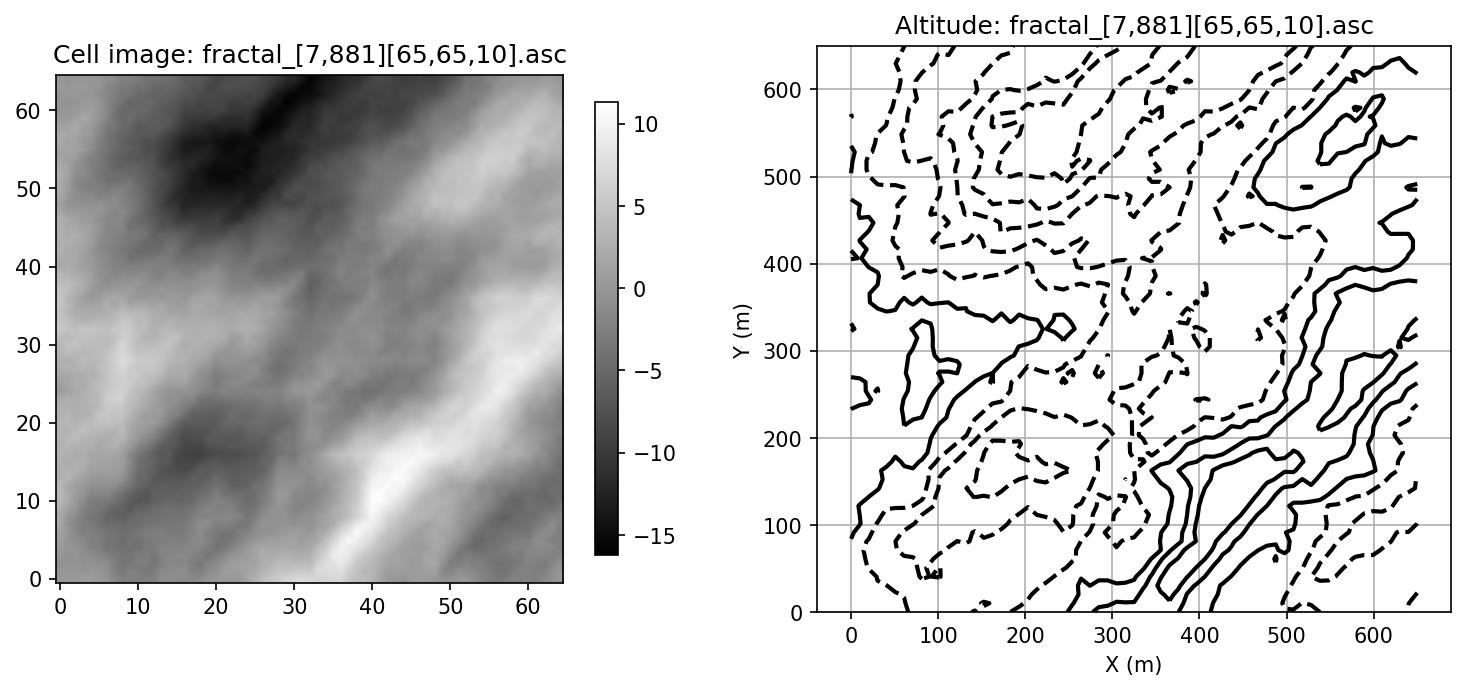

In [12]:
x,y,grid,filename = createFractalTopo('fractal',levels=7,seed=881,cellsize=10,llcorner=[0.,0.,0.])
plotTopo(x,y,grid,filename,'fractal_[7,881][65,65,10].png')